In [1]:
pip install pyarrow


Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install fastparquet


Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd

# Caminho para o arquivo
file_path = "C:/Users/pauli/Desktop/PI6DSM/IndoorOutdoorNet-20K/0000.parquet"

# Carregar o conteúdo
df = pd.read_parquet(file_path)

# Visualizar as primeiras linhas
print(df.head())



                                               image  label
0  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...      0
1  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...      0
2  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...      0
3  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...      0
4  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...      0


In [10]:
# Calculando imagens de fundo necessárias para atingir proporção 70/30

import pandas as pd

# Dados atuais
data = {
    "train": {"total": 14564, "com_rosto": 12996, "sem_rosto": 1568},
    "valid": {"total": 3662, "com_rosto": 3259, "sem_rosto": 403},
    "test":  {"total": 13096, "com_rosto": 12890, "sem_rosto": 206}
}

# Função para calcular imagens sem rosto necessárias
def calcular_adicoes(conjunto):
    com_rosto = conjunto["com_rosto"]
    # Queremos que com_rosto seja 70% do total final
    total_final = com_rosto / 0.7
    sem_rosto_necessario = total_final - com_rosto
    adicionar = int(round(sem_rosto_necessario - conjunto["sem_rosto"]))
    novo_total = com_rosto + conjunto["sem_rosto"] + adicionar
    nova_proporcao = {
        "com_rosto": com_rosto,
        "sem_rosto": conjunto["sem_rosto"] + adicionar,
        "total": novo_total,
        "proporcao_com_rosto": round(com_rosto / novo_total * 100, 2),
        "proporcao_sem_rosto": round((conjunto["sem_rosto"] + adicionar) / novo_total * 100, 2),
        "adicionar": adicionar
    }
    return nova_proporcao

# Aplicar para cada conjunto
resultados = {k: calcular_adicoes(v) for k, v in data.items()}

# Mostrar resultados
df_resultados = pd.DataFrame(resultados).T
print(df_resultados[["com_rosto", "sem_rosto", "total", "proporcao_com_rosto", "proporcao_sem_rosto", "adicionar"]])


       com_rosto  sem_rosto    total  proporcao_com_rosto  \
train    12996.0     5570.0  18566.0                 70.0   
valid     3259.0     1397.0   4656.0                 70.0   
test     12890.0     5524.0  18414.0                 70.0   

       proporcao_sem_rosto  adicionar  
train                 30.0     4002.0  
valid                 30.0      994.0  
test                  30.0     5318.0  


In [ ]:
import pandas as pd
from PIL import Image
import io
import os
import random

# Caminho do arquivo .parquet
file_path = "C:/Users/pauli/Desktop/PI6DSM/IndoorOutdoorNet-20K/0000.parquet"
df = pd.read_parquet(file_path)

# Quantidade total de imagens que você quer usar
total = 10314  # pode aumentar depois se quiser

# Embaralhar os índices para aleatorizar
indices = list(range(len(df)))
random.shuffle(indices)
indices = indices[:total]

# Divisão: 70% treino, 20% validação, 10% teste
train_split = int(0.7 * total)
valid_split = int(0.9 * total)

splits = {
    "train": indices[:train_split],
    "valid": indices[train_split:valid_split],
    "test": indices[valid_split:]
}

# Pasta base
base_dir = "C:/Users/pauli/Desktop/PI6DSM/Treinamento/datasets/IndoorOutdoorNet-20k"


# Salvar imagens e criar labels vazias
for split_name, split_indices in splits.items():
    img_dir = os.path.join(base_dir, split_name, "images")
    label_dir = os.path.join(base_dir, split_name, "labels")
    os.makedirs(img_dir, exist_ok=True)
    os.makedirs(label_dir, exist_ok=True)

    for i, idx in enumerate(split_indices):
        # Salvar imagem
        image_bytes = df.iloc[idx]["image"]["bytes"]
        image = Image.open(io.BytesIO(image_bytes))
        img_path = os.path.join(img_dir, f"bg_{idx}.jpg")
        image.save(img_path)

        # Criar label vazio
        label_path = os.path.join(label_dir, f"bg_{idx}.txt")
        with open(label_path, "w") as f:
            pass  # arquivo vazio

    print(f"{split_name}: {len(split_indices)} imagens e labels salvos.")




train: 7219 imagens e labels salvos.
valid: 2063 imagens e labels salvos.
test: 1032 imagens e labels salvos.


In [11]:
import os

# Pasta base do dataset IndoorOutdoorNet-20k
base_dir = "C:/Users/pauli/Desktop/PI6DSM/Treinamento/datasets/IndoorOutdoorNet-20k"

for split_name in ["train", "valid", "test"]:
    img_dir = os.path.join(base_dir, split_name, "images")
    label_dir = os.path.join(base_dir, split_name, "labels")

    # Listar arquivos
    img_files = [os.path.splitext(f)[0] for f in os.listdir(img_dir) if f.lower().endswith((".jpg", ".png"))]
    label_files = [os.path.splitext(f)[0] for f in os.listdir(label_dir) if f.lower().endswith(".txt")]

    # Transformar em conjuntos para comparação
    img_set = set(img_files)
    label_set = set(label_files)

    # Diferenças
    missing_labels = img_set - label_set   # imagens sem label
    orphan_labels = label_set - img_set    # labels sem imagem

    print(f"\n=== {split_name.upper()} ===")
    print(f"Total imagens: {len(img_set)}")
    print(f"Total labels: {len(label_set)}")
    print(f"Imagens sem label: {len(missing_labels)}")
    print(f"Labels sem imagem: {len(orphan_labels)}")

    if missing_labels:
        print("Exemplo de imagens sem label:", list(missing_labels)[:5])
    if orphan_labels:
        print("Exemplo de labels sem imagem:", list(orphan_labels)[:5])



=== TRAIN ===
Total imagens: 6689
Total labels: 0
Imagens sem label: 6689
Labels sem imagem: 0
Exemplo de imagens sem label: ['bg_10049', 'bg_5534', 'bg_191', 'bg_1460', 'bg_12074']

=== VALID ===
Total imagens: 3681
Total labels: 5704
Imagens sem label: 94
Labels sem imagem: 2117
Exemplo de imagens sem label: ['bg_12961', 'bg_19748', 'bg_11963', 'bg_19071', 'bg_18318']
Exemplo de labels sem imagem: ['bg_12857', 'bg_9143', 'bg_5215', 'bg_1317', 'bg_4253']

=== TEST ===
Total imagens: 2814
Total labels: 0
Imagens sem label: 2814
Labels sem imagem: 0
Exemplo de imagens sem label: ['bg_11341', 'bg_11893', 'bg_3571', 'bg_1460', 'bg_17821']


In [13]:
import os

# Pasta base do dataset IndoorOutdoorNet-20k
base_dir = "C:/Users/pauli/Desktop/PI6DSM/Treinamento/datasets/IndoorOutdoorNet-20k"

for split_name in ["train", "valid", "test"]:
    img_dir = os.path.join(base_dir, split_name, "images")
    label_dir = os.path.join(base_dir, split_name, "labels")
    os.makedirs(label_dir, exist_ok=True)

    # Listar arquivos
    img_files = [os.path.splitext(f)[0] for f in os.listdir(img_dir) if f.lower().endswith((".jpg", ".png"))]
    label_files = [os.path.splitext(f)[0] for f in os.listdir(label_dir) if f.lower().endswith(".txt")]

    img_set = set(img_files)
    label_set = set(label_files)

    # Imagens sem label → criar .txt vazio
    missing_labels = img_set - label_set
    for fname in missing_labels:
        label_path = os.path.join(label_dir, fname + ".txt")
        with open(label_path, "w") as f:
            pass

    # Labels sem imagem → remover
    orphan_labels = label_set - img_set
    for fname in orphan_labels:
        os.remove(os.path.join(label_dir, fname + ".txt"))

    print(f"\n=== {split_name.upper()} ===")
    print(f"Total imagens: {len(img_set)}")
    print(f"Total labels: {len(label_set)}")
    print(f"Labels criados: {len(missing_labels)}")
    print(f"Labels removidos: {len(orphan_labels)}")



=== TRAIN ===
Total imagens: 3869
Total labels: 6689
Labels criados: 0
Labels removidos: 2820

=== VALID ===
Total imagens: 980
Total labels: 3681
Labels criados: 0
Labels removidos: 2701

=== TEST ===
Total imagens: 3869
Total labels: 2814
Labels criados: 1055
Labels removidos: 0


In [14]:
import os

base_path = "C:/Users/pauli/Desktop/PI6DSM/Treinamento/datasets"
sources = {
    "WIDER_FACE": "WIDER_FACE",
    "FaceDetection": "FaceDetection.v27i.yolov11",
    "IndoorOutdoorNet-20k": "IndoorOutdoorNet-20k"
}
splits = ["train", "valid", "test"]

for split in splits:
    total_imgs = 0
    with_face = 0
    without_face = 0

    print(f"\n=== {split.upper()} ===")
    for source_name, source_folder in sources.items():
        img_dir = os.path.join(base_path, source_folder, split, "images")
        label_dir = os.path.join(base_path, source_folder, split, "labels")

        jpg_files = [f for f in os.listdir(img_dir) if f.endswith(".jpg")]
        total_imgs += len(jpg_files)

        for f in jpg_files:
            label_path = os.path.join(label_dir, f.replace(".jpg", ".txt"))
            if os.path.exists(label_path):
                if os.path.getsize(label_path) > 0:
                    with_face += 1
                else:
                    without_face += 1
            else:
                # Se não houver .txt, assume como sem rosto
                without_face += 1

        print(f"{source_name}: {len(jpg_files)} imagens")

    print(f"Total: {total_imgs}")
    print(f"Com rosto: {with_face}")
    print(f"Sem rosto: {without_face}")
    print(f"Proporção: {round(with_face / total_imgs * 100, 2)}% com rosto")



=== TRAIN ===
WIDER_FACE: 12877 imagens
FaceDetection: 132 imagens
IndoorOutdoorNet-20k: 3869 imagens
Total: 16878
Com rosto: 12996
Sem rosto: 3882
Proporção: 77.0% com rosto

=== VALID ===
WIDER_FACE: 3226 imagens
FaceDetection: 38 imagens
IndoorOutdoorNet-20k: 980 imagens
Total: 4244
Com rosto: 3259
Sem rosto: 985
Proporção: 76.79% com rosto

=== TEST ===
WIDER_FACE: 12877 imagens
FaceDetection: 19 imagens
IndoorOutdoorNet-20k: 3869 imagens
Total: 16765
Com rosto: 12890
Sem rosto: 3875
Proporção: 76.89% com rosto


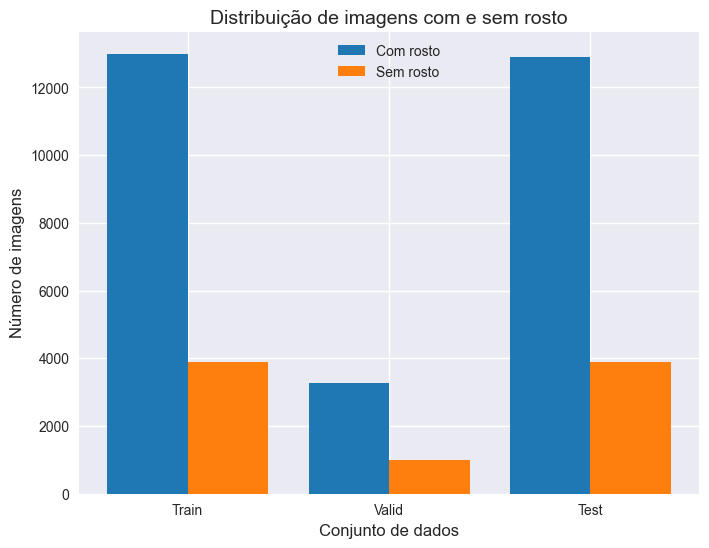

In [16]:
# Gerando gráfico de barras comparando imagens com rosto e sem rosto nos conjuntos train, valid e test
import matplotlib.pyplot as plt

# Dados
datasets = ['Train', 'Valid', 'Test']
with_face = [12996, 3259, 12890]
without_face = [3882, 985, 3875]

# Posição das barras
x = range(len(datasets))
bar_width = 0.4

# Estilo
plt.style.use('seaborn-v0_8')
fig, ax = plt.subplots(figsize=(8, 6))

# Barras
ax.bar([i - bar_width/2 for i in x], with_face, width=bar_width, label='Com rosto', color='#1f77b4')
ax.bar([i + bar_width/2 for i in x], without_face, width=bar_width, label='Sem rosto', color='#ff7f0e')

# Rótulos e título
ax.set_xlabel('Conjunto de dados', fontsize=12)
ax.set_ylabel('Número de imagens', fontsize=12)
ax.set_title('Distribuição de imagens com e sem rosto', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(datasets)
ax.legend()

# Layout e salvar
plt.show()



In [17]:
import torch

print(f"CUDA disponível: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"Nome da GPU: {torch.cuda.get_device_name(0)}")
else:
    print("GPU não detectada.")

CUDA disponível: True
Nome da GPU: NVIDIA GeForce GTX 1650


In [18]:
pip install ultralytics

Note: you may need to restart the kernel to use updated packages.


In [19]:
from ultralytics import YOLO #, settings

In [20]:
from ultralytics.utils.downloads import GITHUB_ASSETS_STEMS
import torch
GITHUB_ASSETS_STEMS

frozenset({'FastSAM-s',
           'FastSAM-x',
           'calibration_image_sample_data_20x128x128x3_float32.npy',
           'mobile_sam',
           'mobileclip_blt',
           'rtdetr-l',
           'rtdetr-x',
           'sam2.1_b',
           'sam2.1_l',
           'sam2.1_s',
           'sam2.1_t',
           'sam2_b',
           'sam2_l',
           'sam2_s',
           'sam2_t',
           'sam_b',
           'sam_l',
           'yolo11l',
           'yolo11l-cls',
           'yolo11l-obb',
           'yolo11l-pose',
           'yolo11l-seg',
           'yolo11m',
           'yolo11m-cls',
           'yolo11m-obb',
           'yolo11m-pose',
           'yolo11m-seg',
           'yolo11n',
           'yolo11n-cls',
           'yolo11n-grayscale',
           'yolo11n-obb',
           'yolo11n-pose',
           'yolo11n-seg',
           'yolo11s',
           'yolo11s-cls',
           'yolo11s-obb',
           'yolo11s-pose',
           'yolo11s-seg',
           'yolo11x',
     

In [21]:
from ultralytics import YOLO, settings
settings

{'settings_version': '0.0.6',
 'datasets_dir': 'C:\\Users\\datasets',
 'weights_dir': 'c:\\Users\\pauli\\weights',
 'runs_dir': './runs',
 'uuid': '8dcdcbf05399dff86d8205edac25d3f2f25410685325067b3a32438616a7e662',
 'sync': True,
 'api_key': '',
 'openai_api_key': '',
 'clearml': True,
 'comet': True,
 'dvc': True,
 'hub': True,
 'mlflow': True,
 'neptune': True,
 'raytune': True,
 'tensorboard': False,
 'wandb': False,
 'vscode_msg': True,
 'openvino_msg': True}

In [22]:
settings.update({'runs_dir': './runs'})

In [23]:
settings

{'settings_version': '0.0.6',
 'datasets_dir': 'C:\\Users\\datasets',
 'weights_dir': 'c:\\Users\\pauli\\weights',
 'runs_dir': './runs',
 'uuid': '8dcdcbf05399dff86d8205edac25d3f2f25410685325067b3a32438616a7e662',
 'sync': True,
 'api_key': '',
 'openai_api_key': '',
 'clearml': True,
 'comet': True,
 'dvc': True,
 'hub': True,
 'mlflow': True,
 'neptune': True,
 'raytune': True,
 'tensorboard': False,
 'wandb': False,
 'vscode_msg': True,
 'openvino_msg': True}

In [24]:
import torch
from ultralytics import YOLO
import os

# --- Configuração do Dispositivo (Já implementado por você, apenas para contexto) ---
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Dispositivo de treino: {device}")
if device == 'cuda':
    print(f"Nome da GPU detectada: {torch.cuda.get_device_name(0)}")
else:
    print("GPU não detectada pelo PyTorch. O treinamento usará a CPU, o que será mais lento.")

Dispositivo de treino: cuda
Nome da GPU detectada: NVIDIA GeForce GTX 1650


In [25]:
model = YOLO('yolo11s.pt')  # yolo11s_custom.yaml

In [26]:
pip install update ultralytics

Note: you may need to restart the kernel to use updated packages.


In [16]:
from pathlib import Path

val_path = Path("C:/Users/pauli/Desktop/PI6DSM/Treinamento/datasets/FaceDetection.v27i.yolov11/valid/images")
print(val_path.exists())
print(list(val_path.glob("*.jpg")))

True
[WindowsPath('C:/Users/pauli/Desktop/PI6DSM/Treinamento/datasets/FaceDetection.v27i.yolov11/valid/images/bg_10000.jpg'), WindowsPath('C:/Users/pauli/Desktop/PI6DSM/Treinamento/datasets/FaceDetection.v27i.yolov11/valid/images/bg_10001.jpg'), WindowsPath('C:/Users/pauli/Desktop/PI6DSM/Treinamento/datasets/FaceDetection.v27i.yolov11/valid/images/bg_10002.jpg'), WindowsPath('C:/Users/pauli/Desktop/PI6DSM/Treinamento/datasets/FaceDetection.v27i.yolov11/valid/images/bg_10006.jpg'), WindowsPath('C:/Users/pauli/Desktop/PI6DSM/Treinamento/datasets/FaceDetection.v27i.yolov11/valid/images/bg_10015.jpg'), WindowsPath('C:/Users/pauli/Desktop/PI6DSM/Treinamento/datasets/FaceDetection.v27i.yolov11/valid/images/bg_10017.jpg'), WindowsPath('C:/Users/pauli/Desktop/PI6DSM/Treinamento/datasets/FaceDetection.v27i.yolov11/valid/images/bg_10019.jpg'), WindowsPath('C:/Users/pauli/Desktop/PI6DSM/Treinamento/datasets/FaceDetection.v27i.yolov11/valid/images/bg_10020.jpg'), WindowsPath('C:/Users/pauli/Deskto

In [17]:
print(len(list(val_path.glob("*.jpg"))))


5890


In [27]:
results = model.train(
    data='custom_dataset.yaml',
    epochs=50,                   # mais épocas para compensar batch pequeno
    batch=4,                      # seguro para 4GB VRAM; se couber, teste 8
    imgsz=416,                    # equilíbrio entre 150x150 e 640x640
    workers=4,                    # não sobrecarregar CPU junto com GPU
    pretrained=True,
    cache=True,                   # acelera, mas cuidado com RAM
    val=True,
    patience=10,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    box=5.0,
    cls=0.5,
    dfl=2.0,
    degrees=0.0,
    hsv_s=0.3,
    hsv_v=0.3,
    scale=0.5,
    fliplr=0.5,
    flipud=0.1,
    mosaic=0.5,
    close_mosaic=10               # estabiliza nas últimas épocas
)


New https://pypi.org/project/ultralytics/8.3.228 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.152  Python-3.12.4 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce GTX 1650, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=5.0, cache=True, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=custom_dataset.yaml, degrees=0.0, deterministic=True, device=0, dfl=2.0, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.1, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.3, hsv_v=0.3, imgsz=416, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s.pt, momentum=0.937, mosaic=0.5, multi_scale=False, name=train37, nbs=64, nms=False, opset=None, optimize=False

train: Scanning C:\Users\pauli\Desktop\PI6DSM\Treinamento\datasets\FaceDetection.v27i.yolov11\train\labels... 13009 images, 13 backgrounds, 0 corrupt: 100%|██████████| 13009/13009 [00:21<00:00, 617.21it/s]

train: C:\Users\pauli\Desktop\PI6DSM\Treinamento\datasets\WIDER_FACE\train\images\2_Demonstration_Protesters_2_231_jpg.rf.14b6ba970f3a34843cf41706cf802e37.jpg: 1 duplicate labels removed
train: C:\Users\pauli\Desktop\PI6DSM\Treinamento\datasets\WIDER_FACE\train\images\37_Soccer_Soccer_37_851_jpg.rf.9626888f7c524f523f123df5c7417573.jpg: 1 duplicate labels removed
train: C:\Users\pauli\Desktop\PI6DSM\Treinamento\datasets\WIDER_FACE\train\images\7_Cheering_Cheering_7_17_jpg.rf.f33362e0b02002a17ce25e9fcc6c6650.jpg: 1 duplicate labels removed


train: New cache created: C:\Users\pauli\Desktop\PI6DSM\Treinamento\datasets\FaceDetection.v27i.yolov11\train\labels.cache
WARNING train: 9.4GB RAM required to cache images with 50% safety margin but only 0.7/15.8GB available, not caching images
val: Fast image access  (ping: 0.10.0 ms, read: 94.931.0 MB/s, size: 50.7 KB)


val: Scanning C:\Users\pauli\Desktop\PI6DSM\Treinamento\datasets\FaceDetection.v27i.yolov11\valid\labels... 3264 images, 5 backgrounds, 0 corrupt: 100%|██████████| 3264/3264 [00:05<00:00, 633.42it/s]

val: C:\Users\pauli\Desktop\PI6DSM\Treinamento\datasets\WIDER_FACE\valid\images\21_Festival_Festival_21_604_jpg.rf.f65a6018a5c9c5f0a3f93bbe84b46203.jpg: 1 duplicate labels removed


val: New cache created: C:\Users\pauli\Desktop\PI6DSM\Treinamento\datasets\FaceDetection.v27i.yolov11\valid\labels.cache
WARNING val: 2.3GB RAM required to cache images with 50% safety margin but only 0.5/15.8GB available, not caching images
Plotting labels to runs\detect\train37\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 416 train, 416 val
Using 4 dataloader workers
Logging results to runs\detect\train37
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      1.73G      1.267      1.321      1.595         15        416: 100%|██████████| 3253/3253 [08:27<00:00,  6.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 408/408 [00:45<00:00,  9.05it/s]


                   all       3264      39745      0.723       0.38      0.445      0.218

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      1.82G      1.185       1.09      1.469          5        416: 100%|██████████| 3253/3253 [07:45<00:00,  6.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 408/408 [00:44<00:00,  9.07it/s]


                   all       3264      39745      0.728      0.392      0.443      0.211

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50       1.8G      1.233      1.185      1.514          1        416: 100%|██████████| 3253/3253 [07:42<00:00,  7.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 408/408 [00:44<00:00,  9.09it/s]


                   all       3264      39745      0.703      0.368      0.419      0.201

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      2.16G      1.242      1.206      1.533          5        416: 100%|██████████| 3253/3253 [07:41<00:00,  7.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 408/408 [00:45<00:00,  9.06it/s]


                   all       3264      39745       0.71      0.368      0.421      0.206

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      2.08G      1.205       1.13      1.508          7        416: 100%|██████████| 3253/3253 [07:42<00:00,  7.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 408/408 [00:44<00:00,  9.20it/s]


                   all       3264      39745      0.729      0.394      0.448      0.224

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      1.74G      1.183      1.091      1.494          1        416: 100%|██████████| 3253/3253 [07:43<00:00,  7.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 408/408 [00:44<00:00,  9.20it/s]


                   all       3264      39745      0.737      0.405      0.462      0.233

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50       1.9G      1.159      1.053      1.474         15        416: 100%|██████████| 3253/3253 [07:41<00:00,  7.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 408/408 [00:44<00:00,  9.14it/s]


                   all       3264      39745      0.749      0.414      0.473      0.241

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      2.15G      1.138      1.015      1.462          5        416: 100%|██████████| 3253/3253 [07:41<00:00,  7.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 408/408 [00:44<00:00,  9.19it/s]


                   all       3264      39745      0.767      0.412      0.477      0.244

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      1.82G      1.124     0.9901      1.453          4        416: 100%|██████████| 3253/3253 [07:40<00:00,  7.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 408/408 [00:44<00:00,  9.13it/s]


                   all       3264      39745      0.763      0.428      0.491       0.25

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      1.56G      1.098     0.9544      1.438         11        416: 100%|██████████| 3253/3253 [07:40<00:00,  7.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 408/408 [00:44<00:00,  9.11it/s]


                   all       3264      39745      0.778      0.433      0.501      0.258

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      2.11G      1.087     0.9371      1.429         18        416: 100%|██████████| 3253/3253 [07:41<00:00,  7.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 408/408 [00:44<00:00,  9.17it/s]


                   all       3264      39745      0.768       0.44      0.505       0.26

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      1.83G      1.085      0.924      1.425          4        416: 100%|██████████| 3253/3253 [07:40<00:00,  7.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 408/408 [00:44<00:00,  9.18it/s]


                   all       3264      39745      0.778      0.445      0.512      0.266

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      1.93G      1.078     0.9121      1.412          2        416: 100%|██████████| 3253/3253 [07:41<00:00,  7.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 408/408 [00:44<00:00,  9.16it/s]


                   all       3264      39745      0.779      0.452      0.521      0.269

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      2.11G      1.069     0.8959      1.407          5        416: 100%|██████████| 3253/3253 [07:41<00:00,  7.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 408/408 [00:44<00:00,  9.20it/s]


                   all       3264      39745      0.783      0.451      0.517       0.27

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      1.66G       1.06     0.8883      1.413          1        416: 100%|██████████| 3253/3253 [07:41<00:00,  7.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 408/408 [00:44<00:00,  9.15it/s]


                   all       3264      39745      0.787      0.452      0.522       0.27

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      1.79G      1.055     0.8811      1.399          1        416: 100%|██████████| 3253/3253 [07:40<00:00,  7.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 408/408 [00:45<00:00,  8.97it/s]


                   all       3264      39745      0.787      0.463       0.53      0.278

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      2.01G      1.051     0.8714        1.4          2        416: 100%|██████████| 3253/3253 [07:41<00:00,  7.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 408/408 [00:44<00:00,  9.17it/s]


                   all       3264      39745      0.795      0.457       0.53      0.279

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      1.46G      1.046      0.859        1.4          1        416: 100%|██████████| 3253/3253 [07:40<00:00,  7.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 408/408 [00:44<00:00,  9.17it/s]


                   all       3264      39745      0.788      0.466      0.536       0.28

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      2.32G       1.03     0.8471      1.389         13        416: 100%|██████████| 3253/3253 [07:41<00:00,  7.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 408/408 [00:44<00:00,  9.18it/s]


                   all       3264      39745      0.793       0.47      0.538      0.285

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      1.98G       1.03     0.8418      1.386          1        416: 100%|██████████| 3253/3253 [07:40<00:00,  7.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 408/408 [00:44<00:00,  9.21it/s]


                   all       3264      39745      0.801      0.467       0.54      0.285

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50         2G      1.034     0.8413       1.38          1        416: 100%|██████████| 3253/3253 [07:41<00:00,  7.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 408/408 [00:44<00:00,  9.23it/s]


                   all       3264      39745        0.8      0.471      0.543      0.287

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50       1.9G      1.028      0.832      1.377         13        416: 100%|██████████| 3253/3253 [07:40<00:00,  7.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 408/408 [00:44<00:00,  9.19it/s]


                   all       3264      39745      0.803      0.472      0.546       0.29

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      2.33G      1.016     0.8188      1.372          1        416: 100%|██████████| 3253/3253 [07:41<00:00,  7.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 408/408 [00:44<00:00,  9.22it/s]


                   all       3264      39745      0.805      0.476      0.549      0.292

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      1.98G      1.019     0.8192      1.373          1        416: 100%|██████████| 3253/3253 [07:41<00:00,  7.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 408/408 [00:44<00:00,  9.09it/s]


                   all       3264      39745      0.802      0.483      0.555      0.294

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      1.58G      1.011     0.8127       1.37          2        416: 100%|██████████| 3253/3253 [07:40<00:00,  7.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 408/408 [00:44<00:00,  9.19it/s]


                   all       3264      39745      0.812       0.48      0.557      0.296

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      1.85G      1.004     0.8034      1.363          3        416: 100%|██████████| 3253/3253 [07:40<00:00,  7.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 408/408 [00:44<00:00,  9.21it/s]


                   all       3264      39745       0.81      0.482      0.558      0.297

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      1.81G      1.002     0.7966      1.363         12        416: 100%|██████████| 3253/3253 [07:40<00:00,  7.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 408/408 [00:44<00:00,  9.20it/s]


                   all       3264      39745      0.808      0.487      0.558      0.298

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      1.75G      1.002     0.7966      1.359          1        416: 100%|██████████| 3253/3253 [07:40<00:00,  7.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 408/408 [00:45<00:00,  8.87it/s]


                   all       3264      39745      0.809      0.484      0.557      0.298

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      1.79G     0.9972     0.7897      1.356          9        416: 100%|██████████| 3253/3253 [07:41<00:00,  7.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 408/408 [00:44<00:00,  9.18it/s]


                   all       3264      39745       0.81      0.488      0.562      0.302

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      1.43G     0.9898      0.778      1.352          1        416: 100%|██████████| 3253/3253 [07:40<00:00,  7.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 408/408 [00:44<00:00,  9.08it/s]


                   all       3264      39745      0.808      0.494      0.567      0.304

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      1.95G     0.9883     0.7778      1.349          0        416: 100%|██████████| 3253/3253 [07:40<00:00,  7.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 408/408 [00:44<00:00,  9.18it/s]


                   all       3264      39745       0.81      0.493      0.569      0.305

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      1.85G     0.9877     0.7757      1.351          2        416: 100%|██████████| 3253/3253 [07:40<00:00,  7.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 408/408 [00:45<00:00,  9.06it/s]


                   all       3264      39745      0.807      0.497      0.571      0.307

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      2.04G     0.9823      0.764      1.349          1        416: 100%|██████████| 3253/3253 [07:40<00:00,  7.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 408/408 [00:44<00:00,  9.19it/s]


                   all       3264      39745      0.811      0.493      0.569      0.306

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      2.21G     0.9672     0.7493      1.339        100        416: 100%|██████████| 3253/3253 [07:41<00:00,  7.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 408/408 [00:44<00:00,  9.21it/s]


                   all       3264      39745      0.815      0.494      0.571      0.307

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      1.41G     0.9764     0.7574      1.346         47        416: 100%|██████████| 3253/3253 [07:40<00:00,  7.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 408/408 [00:44<00:00,  9.16it/s]


                   all       3264      39745      0.812        0.5      0.575      0.309

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      1.64G     0.9709     0.7501      1.344          2        416: 100%|██████████| 3253/3253 [07:41<00:00,  7.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 408/408 [00:44<00:00,  9.16it/s]


                   all       3264      39745      0.814      0.497      0.575       0.31

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      1.83G     0.9628     0.7385      1.337          1        416: 100%|██████████| 3253/3253 [07:40<00:00,  7.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 408/408 [00:44<00:00,  9.22it/s]


                   all       3264      39745      0.812      0.502      0.577      0.311

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      1.79G     0.9619     0.7385      1.333         63        416: 100%|██████████| 3253/3253 [07:40<00:00,  7.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 408/408 [00:44<00:00,  9.22it/s]


                   all       3264      39745      0.814      0.503      0.579      0.313

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50         2G     0.9617     0.7358      1.339         12        416: 100%|██████████| 3253/3253 [07:41<00:00,  7.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 408/408 [00:44<00:00,  9.18it/s]


                   all       3264      39745      0.817      0.502      0.578      0.313

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      1.49G     0.9532     0.7243      1.333         20        416: 100%|██████████| 3253/3253 [07:41<00:00,  7.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 408/408 [00:44<00:00,  9.23it/s]


                   all       3264      39745       0.82      0.501       0.58      0.314
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      2.15G      0.939     0.6983      1.327         15        416: 100%|██████████| 3253/3253 [07:40<00:00,  7.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 408/408 [00:44<00:00,  9.22it/s]


                   all       3264      39745      0.821        0.5      0.579      0.313

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      2.09G     0.9319      0.689      1.322          1        416: 100%|██████████| 3253/3253 [07:39<00:00,  7.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 408/408 [00:44<00:00,  9.21it/s]


                   all       3264      39745      0.817      0.504      0.581      0.314

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      2.03G     0.9261     0.6789       1.32          1        416: 100%|██████████| 3253/3253 [07:40<00:00,  7.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 408/408 [00:44<00:00,  9.21it/s]


                   all       3264      39745       0.82      0.501       0.58      0.313

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      1.98G     0.9249     0.6801      1.314          9        416: 100%|██████████| 3253/3253 [07:40<00:00,  7.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 408/408 [00:44<00:00,  9.16it/s]


                   all       3264      39745      0.823      0.501      0.582      0.314

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      1.92G     0.9156     0.6681      1.312          1        416: 100%|██████████| 3253/3253 [07:39<00:00,  7.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 408/408 [00:44<00:00,  9.20it/s]


                   all       3264      39745      0.823      0.503      0.583      0.315

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      2.18G     0.9169     0.6684      1.313         26        416: 100%|██████████| 3253/3253 [07:40<00:00,  7.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 408/408 [00:44<00:00,  9.17it/s]


                   all       3264      39745      0.818      0.507      0.583      0.316

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      1.82G     0.9085     0.6565      1.307          5        416: 100%|██████████| 3253/3253 [07:40<00:00,  7.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 408/408 [00:44<00:00,  9.25it/s]


                   all       3264      39745      0.818      0.507      0.584      0.316

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      2.07G     0.9054     0.6524      1.302          2        416: 100%|██████████| 3253/3253 [07:40<00:00,  7.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 408/408 [00:44<00:00,  9.21it/s]


                   all       3264      39745       0.82      0.507      0.584      0.316

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      1.82G     0.9042     0.6478      1.303         17        416: 100%|██████████| 3253/3253 [07:40<00:00,  7.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 408/408 [00:44<00:00,  9.23it/s]


                   all       3264      39745      0.818      0.507      0.584      0.316

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      1.84G     0.9007     0.6434      1.302          5        416: 100%|██████████| 3253/3253 [07:40<00:00,  7.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 408/408 [00:44<00:00,  9.21it/s]


                   all       3264      39745       0.82      0.507      0.585      0.317

50 epochs completed in 7.050 hours.
Optimizer stripped from runs\detect\train37\weights\last.pt, 19.1MB
Optimizer stripped from runs\detect\train37\weights\best.pt, 19.1MB

Validating runs\detect\train37\weights\best.pt...
Ultralytics 8.3.152  Python-3.12.4 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce GTX 1650, 4096MiB)
YOLO11s summary (fused): 100 layers, 9,413,187 parameters, 0 gradients, 21.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 408/408 [00:37<00:00, 10.95it/s]


                   all       3264      39745      0.821      0.507      0.585      0.317
Speed: 0.3ms preprocess, 7.1ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs\detect\train37
